<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/food_habits_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food habits analytics

## Uploading packages and data

In [1]:
#Importing necessary packages
import numpy as np
import pandas as pd

In [ ]:
#Remove previous versions of the uploaded excel file
!rm food_habits.xlsx

In [2]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

Saving food_habits.xlsx to food_habits.xlsx


In [3]:
#Storing dataset in a Pandas Dataframe
import io
df1 = pd.read_excel(io.BytesIO(uploaded1['food_habits.xlsx']))

In [4]:
#Checking the dataframe info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        84 non-null     datetime64[ns]
 1   time        84 non-null     object        
 2   food        84 non-null     object        
 3   large_meal  84 non-null     int64         
 4   ache        84 non-null     int64         
 5   event       84 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 4.1+ KB


In [5]:
#Checking the dataframe head
df1.head(2)

,date,time,food,large_meal,ache,event
0,2020-07-29,21:05:00,"bread, pepperoni, ham, cheese, ricotta, mustar...",1,1,2020-07-29 21:05:00
1,2020-08-02,22:00:00,"pasta, tuna, mayonaise, mustard, carrots, cele...",0,1,2020-08-02 22:00:00


##Data Manipulation

In [6]:
#Extracting year, month, day of week, hour and count of ingredients
df1 = df1.assign(date_2 = df1['date'].shift(fill_value=np.nan), 
                 year = df1['event'].dt.year,
                 month = df1['event'].dt.month,
                 day = df1['event'].dt.dayofweek,
                 hour = df1['event'].dt.hour,
                 ing_count = [len(i.split(', ')) for i in df1['food']])
df1.tail()

,date,time,food,large_meal,ache,event,date_2,year,month,day,hour,ing_count
79,2021-08-11,18:36:00,"frozen_chicken, avocado, lettuce, sweet_corn, ...",1,1,2021-08-11 18:36:00,2021-08-08,2021,8,2,18,7
80,2021-08-20,02:00:00,"bread, mayonaise, salami, rice, tuna, oil, keb...",1,1,2021-08-20 02:00:00,2021-08-11,2021,8,4,2,14
81,2021-08-27,18:00:00,"cream, chicken_tikamasala, rice, rice, soda, b...",1,1,2021-08-27 18:00:00,2021-08-20,2021,8,4,18,9
82,2021-09-03,18:40:00,"mince, canned_beans, sweet_corn, carrots, wine...",1,1,2021-09-03 18:40:00,2021-08-27,2021,9,4,18,23
83,2021-09-04,18:45:00,"dough, cheese, cheese, cheese, cheese, salami,...",1,1,2021-09-04 18:45:00,2021-09-03,2021,9,5,18,16


In [7]:
#Calculating range of days between events and converting to int (days)
df1 = df1.assign(num_of_days = (df1['date'] - df1['date_2']))
df1 = df1.assign(num_of_days = df1['num_of_days'].replace(np.nan, 0))
df1 = df1.assign(num_of_days = (df1['num_of_days'].astype(int))/8.64e+13) #==> Converting from ns to days
df1.tail()

,date,time,food,large_meal,ache,event,date_2,year,month,day,hour,ing_count,num_of_days
79,2021-08-11,18:36:00,"frozen_chicken, avocado, lettuce, sweet_corn, ...",1,1,2021-08-11 18:36:00,2021-08-08,2021,8,2,18,7,3.0
80,2021-08-20,02:00:00,"bread, mayonaise, salami, rice, tuna, oil, keb...",1,1,2021-08-20 02:00:00,2021-08-11,2021,8,4,2,14,9.0
81,2021-08-27,18:00:00,"cream, chicken_tikamasala, rice, rice, soda, b...",1,1,2021-08-27 18:00:00,2021-08-20,2021,8,4,18,9,7.0
82,2021-09-03,18:40:00,"mince, canned_beans, sweet_corn, carrots, wine...",1,1,2021-09-03 18:40:00,2021-08-27,2021,9,4,18,23,7.0
83,2021-09-04,18:45:00,"dough, cheese, cheese, cheese, cheese, salami,...",1,1,2021-09-04 18:45:00,2021-09-03,2021,9,5,18,16,1.0


In [8]:
#Checking the number of unique categories for number of days column
df1['num_of_days'].unique()

array([ 0.,  4.,  2.,  8., 16.,  3., 67., 54.,  5., 17., 11.,  1., 21.,
       13.,  6.,  7., 12., 25.,  9.])

In [9]:
#Filtering the dataframe and assigning categories for 2021 where stomach ache appeared
df1_2021 = df1[(df1['year']==2021) & (df1['ache']==1) & (~df1['month'].isin([1, 2])) & (df1['num_of_days']>=1)].reset_index(drop=True)
df1_2021 = df1_2021.assign(cat = np.where(df1_2021['month']<6, 'milk_diet', 'lactose_free'))
df1_2021.tail(2)

,date,time,food,large_meal,ache,event,date_2,year,month,day,hour,ing_count,num_of_days,cat
29,2021-09-03,18:40:00,"mince, canned_beans, sweet_corn, carrots, wine...",1,1,2021-09-03 18:40:00,2021-08-27,2021,9,4,18,23,7.0,lactose_free
30,2021-09-04,18:45:00,"dough, cheese, cheese, cheese, cheese, salami,...",1,1,2021-09-04 18:45:00,2021-09-03,2021,9,5,18,16,1.0,lactose_free


In [10]:
#Transforming aching meals into list
ache_1 = df1[df1['ache']==1]['food'].str.cat(sep=', ').split(", ")
ache_1[:5]

['bread', 'pepperoni', 'ham', 'cheese', 'ricotta']

In [11]:
#Building a dictionary of occurrences for each food
import collections
ache_occurrences = collections.Counter(ache_1)
ache_occurrences.get('bread')

16

In [12]:
#Transforming list of aching meals into series
ache_meal_1 = pd.Series(data=ache_1)
ache_meal_1.tail()

665             olives
666         champignon
667          hot_sauce
668              juice
669    chocolate_pudin
dtype: object

In [13]:
#Counting top aching foods
ache_meal_1 = ache_meal_1.value_counts().reset_index(name='count').rename(columns={'index':'food'})
ache_meal_1.head()

,food,count
0,cheese,29
1,rice,24
2,chocolate,20
3,olive_oil,19
4,onion,19


In [ ]:
#Exporting to excel into local disk
from google.colab import files
ache_meal_1.to_excel('food_count.xlsx', index=False) #==> Excluding index from file
files.download('food_count.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Data Visualization

In [14]:
#Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (10, 4)})

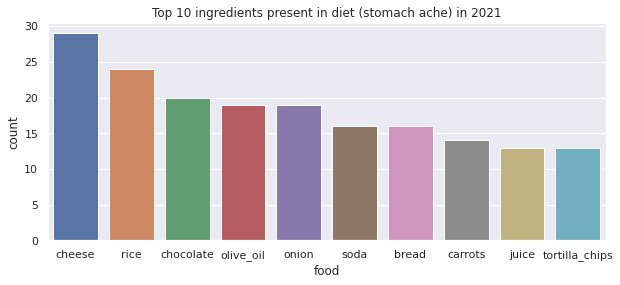

In [16]:
#Plotting the top 10 estomach aching meals
sns.barplot(x='food', y='count', data=ache_meal_1[:10])
plt.title('Top 10 ingredients present in diet (stomach ache) in 2021')
plt.show()

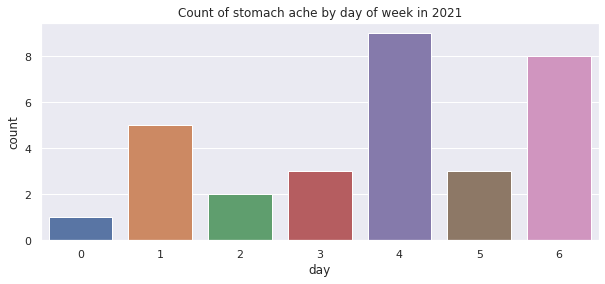

In [17]:
#Plotting the number of stomach ache by day of the week
sns.countplot(x='day', data=df1_2021)
plt.title('Count of stomach ache by day of week in 2021')
plt.show()

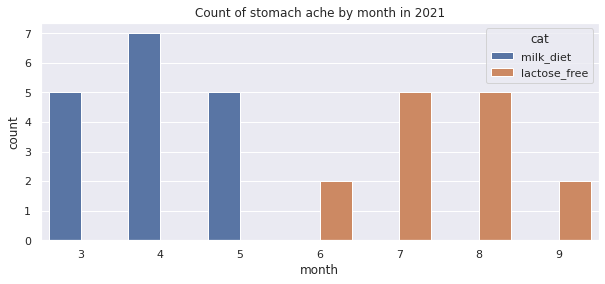

In [18]:
#Plotting the number of stomach ache by month
sns.countplot(x='month', data=df1_2021, hue='cat')
plt.title('Count of stomach ache by month in 2021')
plt.show()

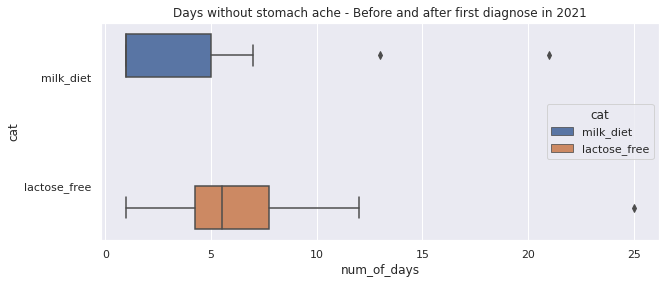

In [19]:
#Plotting the boxplot of days between stomach ache
sns.boxplot(x='num_of_days', y='cat', data=df1_2021, hue='cat')
plt.title('Days without stomach ache - Before and after first diagnose in 2021')
plt.show()

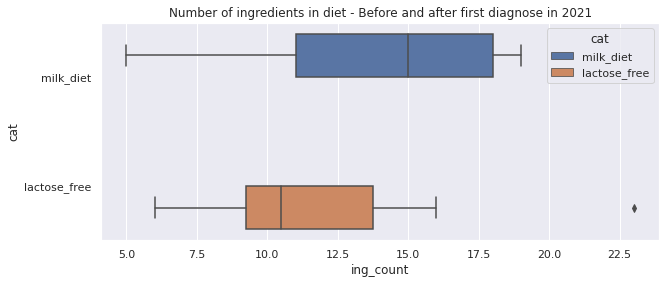

In [20]:
#Plotting the boxplot of number of ingredients present in diet
sns.boxplot(x='ing_count', y='cat', data=df1_2021, hue='cat')
plt.title('Number of ingredients in diet - Before and after first diagnose in 2021')
plt.show()

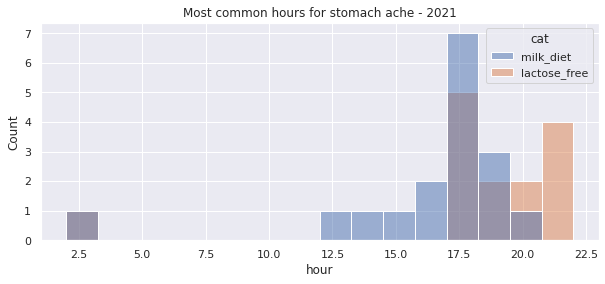

In [21]:
#Plotting the histogram of hours for stomach ache
sns.histplot(x='hour', data=df1_2021, hue='cat')
plt.title('Most common hours for stomach ache - 2021')
plt.show()